In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib

In [52]:
# paths to load datasets from
train_store_path = './datasets/sa/training'
val_store_path = './datasets/sa/validation'

# convert to pathlib Path objects
train_dir = pathlib.Path(train_store_path)
val_dir = pathlib.Path(val_store_path)

# get list of datasets in dir
train_ds_paths = sorted(list(train_dir.glob('*.csv')))
val_ds_paths = sorted(list(val_dir.glob('*.csv')))

# extract classification target from file names
train_ds_type = np.array([x.parts[-1].split('_')[:2] for x in train_ds_paths])
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])

train_ds_order = [s.upper() for s in train_ds_type[:,0]]
val_ds_order = [s.upper() for s in val_ds_type[:,0]]

train_ds_loc = [s.upper() for s in train_ds_type[:, 1]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in train_ds_order])))}

### How it works
1. dataset storage directory paths are first defined
2. paths are used to define a pathlib `Path` object
3. `Path` objects are turned into a list of paths directly referencing each dataset using the `.glob()` function
4. signal types are determined by the dataset file name, opened in this format: `[<signal type>, <collection location>]`
5. signal type tags are generated as a dictionary in this format: `{<signal type> : <numeric tag>}` where `<numeric tag>` is ordered based on the alphanumeric order of the present signal types

In [58]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [train_ds_paths, val_ds_paths]:
    temp_ds = []
    temp_specs = []
    
    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_ds.append(df)
        
    datasets.append(temp_ds)
    specs.append(temp_specs)
    
print('done.')

loading datasets/sa/training/bt_library_1.csv... loaded
loading datasets/sa/training/bt_office_1.csv... loaded
loading datasets/sa/training/bt_room_1.csv... loaded
loading datasets/sa/training/fm_roof_1.csv... loaded
loading datasets/sa/training/fnet_library_1.csv... loaded
loading datasets/sa/training/fnet_roof_1.csv... loaded
loading datasets/sa/training/fnet_room_1.csv... loaded
loading datasets/sa/training/lte_library_1.csv... loaded
loading datasets/sa/training/lte_library_2.csv... loaded
loading datasets/sa/training/lte_library_3.csv... loaded
loading datasets/sa/training/lte_office_1.csv... loaded
loading datasets/sa/training/lte_office_2.csv... loaded
loading datasets/sa/training/lte_room_1.csv... loaded
loading datasets/sa/training/lte_room_2.csv... loaded
loading datasets/sa/training/lte_room_3.csv... loaded
loading datasets/sa/training/wifi_library_1.csv... loaded
loading datasets/sa/training/wifi_library_2.csv... loaded
loading datasets/sa/training/wifi_library_3.csv... loa

In [59]:
np.unique(train_ds_order)

array(['BT', 'FM', 'FNET', 'LTE', 'WIFI'], dtype='<U4')

In [60]:
specs[0][4]

,info
SamplingFrequency,875000
NumberSamples,1024
NumberRecords,6343


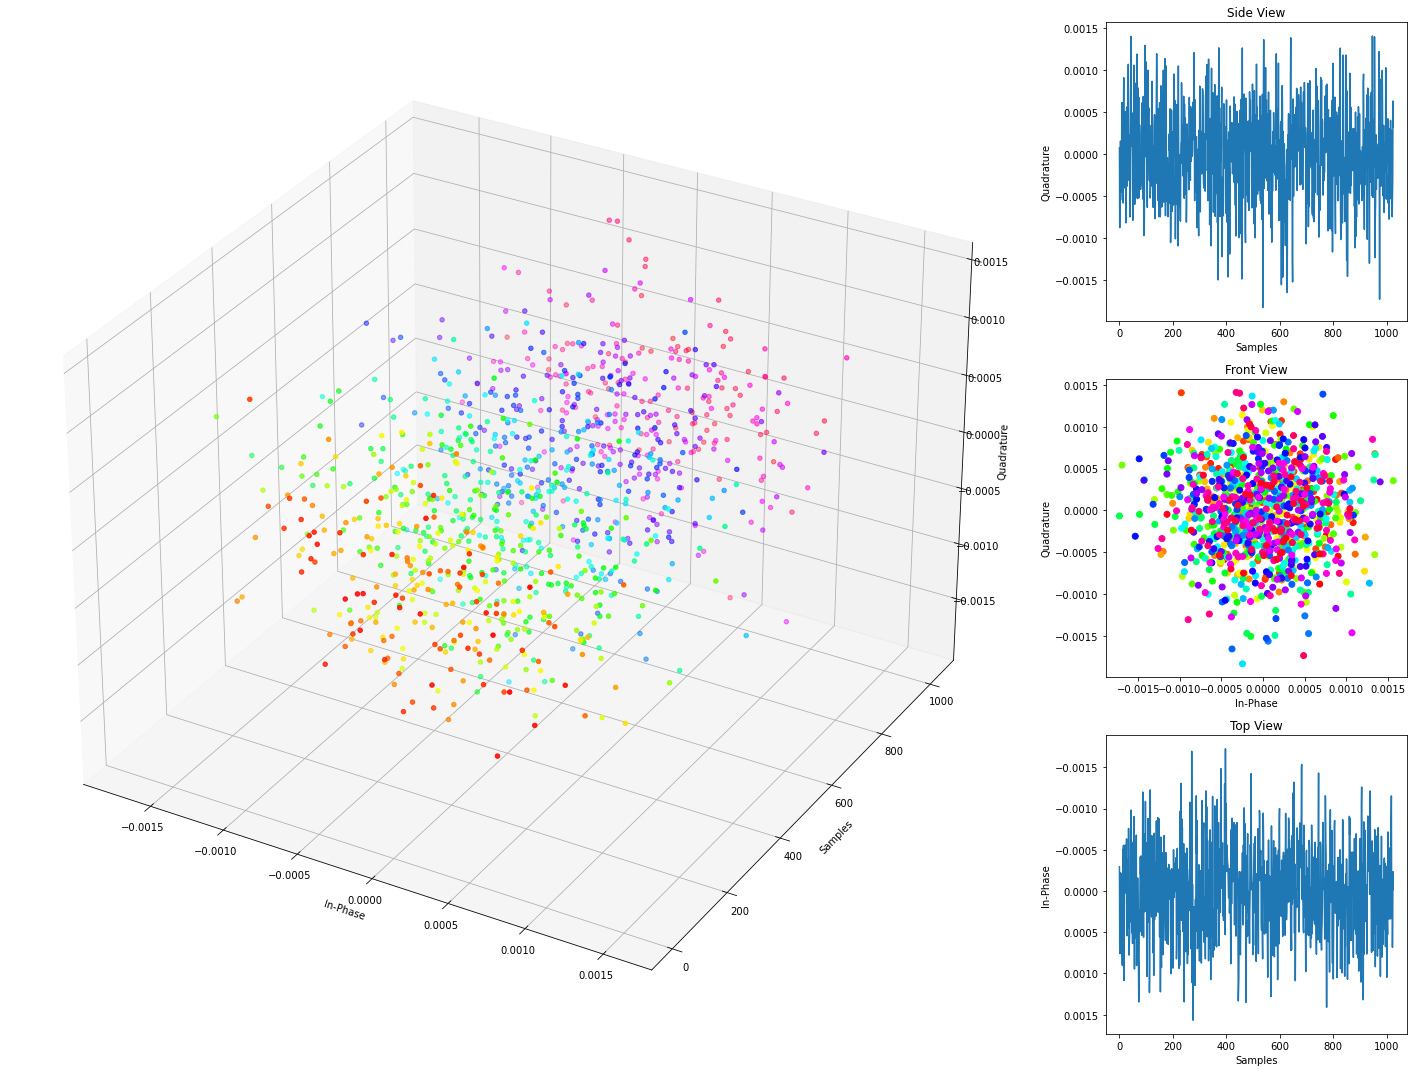

In [61]:
# plot a record sample
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:3, :3], projection='3d')

x = datasets[0][2].iloc[:specs[0][2].loc['NumberSamples']['info']]['I'].values
z = datasets[0][2].iloc[:specs[0][2].loc['NumberSamples']['info']]['Q'].values
y = np.arange(1, specs[0][2].loc['NumberSamples']['info']+1)

ax.scatter(x, y, z, c=y, cmap='hsv')
ax.set_xlabel('In-Phase')
ax.set_ylabel('Samples')
ax.set_zlabel('Quadrature')

ax1 = fig.add_subplot(gs[0, 3])
ax1.plot(y, z)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Quadrature')
ax1.set_title('Side View')

ax2 = fig.add_subplot(gs[1, 3])
ax2.scatter(x, z, c=y, cmap='hsv')
ax2.set_xlabel('In-Phase')
ax2.set_ylabel('Quadrature')
ax2.set_title('Front View')

ax3 = fig.add_subplot(gs[2, 3])
ax3.plot(y, x)
ax3.set_xlabel('Samples')
ax3.set_ylabel('In-Phase')
ax3.set_title('Top View')
ax3.invert_yaxis()


plt.tight_layout()
plt.show()

In [62]:
# split dataset(s) into records, extract test dataset
processed = []

# number of test records to extract
ntest = 100
rlength = 1024

for h in range(len(datasets)):
    temp_processed = []
    
    print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
    for i in range(len(datasets[h])):
        nrecords = specs[h][i].loc['NumberRecords']['info']
        nsamples = specs[h][i].loc['NumberSamples']['info']
        ds_length = datasets[h][i].shape[0]
        
        # make life easier
        ds_order = train_ds_order if not h else val_ds_order
        ds_loc = train_ds_loc if not h else val_ds_loc

        # sanity check
        print(f'{ds_order[i]:<13}\t{ds_loc[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = datasets[h][i].iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            temp_processed.append([ds_order[i], signal_tags[ds_order[i]], ds_loc[i], record])
            
    processed.append(temp_processed)

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(processed[0], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test = pd.DataFrame(processed[1], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BT           	LIBRARY        	5869   		1024   
BT           	OFFICE         	23885  		1014   
BT           	ROOM           	9000   		1024   
FM           	ROOF           	5701   		1280   
FNET         	LIBRARY        	6343   		1024   
FNET         	ROOF           	3151   		1024   
FNET         	ROOM           	2450   		1024   
LTE          	LIBRARY        	1200   		1024   
LTE          	LIBRARY        	1450   		1024   
LTE          	LIBRARY        	1500   		1024   
LTE          	OFFICE         	3202   		1014   
LTE          	OFFICE         	3550   		1014   
LTE          	ROOM           	1850   		1024   
LTE          	ROOM           	1650   		1024   
LTE          	ROOM           	1300   		1024   
WIFI         	LIBRARY        	1250   		1024   
WIFI         	LIBRARY        	1200   		1024   
WIFI         	LIBRARY        	1350   		1024   
WIFI         	OFFICE         	1200   		1014   
WIFI         	OFFICE         	2699   		1014   
WIFI         	R

In [63]:
df_train.head(3)

,signal_type,tag,location,record
39481,FM,1,ROOF,"[[7.25e-06, 0.0002616, 0.00065971, 2.948e-05, ..."
76885,WIFI,4,OFFICE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.9..."
78969,WIFI,4,OFFICE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [52]:
# ensure no data gets corrupted in processing
I_check = sum(df_records['record'].iloc[0][0] == df.iloc[:df_spec.loc['NumberSamples']['info']]['I'].values) == df_spec.loc['NumberSamples']['info']
Q_check = sum(df_records['record'].iloc[0][1] == df.iloc[:df_spec.loc['NumberSamples']['info']]['Q'].values) == df_spec.loc['NumberSamples']['info']

print(f'I check: {I_check} | Q check: {Q_check}')

I check: True | Q check: True
